In [2]:
import sys
sys.path.append("..")
import uproot
import awkward as ak
from binary_decoders import lecroy

import matplotlib.pyplot as plt
from importlib import reload

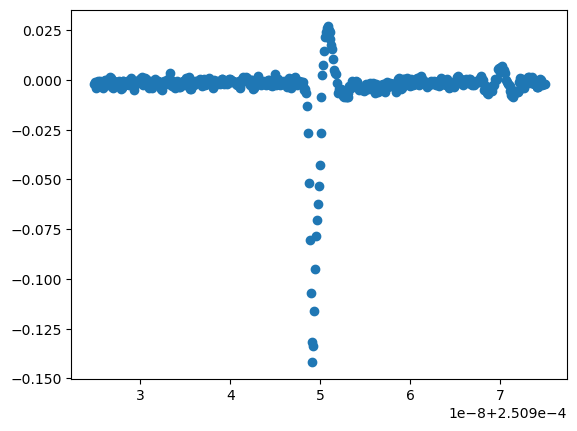

In [ ]:
reload(lecroy)

C1 = lecroy.LecroyReader("unit_test/input_data/run_5100/C1--Trace5100.trc")
C2 = lecroy.LecroyReader("unit_test/input_data/run_5100/C2--Trace5100.trc") # TRIGGER
C3 = lecroy.LecroyReader("unit_test/input_data/run_5100/C3--Trace5100.trc") # CLOCK
C4 = lecroy.LecroyReader("unit_test/input_data/run_5100/C4--Trace5100.trc")

C = C2
plt.scatter(C.x[1], C.y[-1])

In [ ]:
import awkward as ak

array = ak.Array({
    'i_evt': [i for i in range(len(t))],
    'seconds': x,
    'volts': y 
})

output_path = "test.root"
with uproot.recreate(output_path) as file:
    file["pulse"] = array


In [61]:
old = uproot.open(
    "converted_run5100.root"
)["pulse"].arrays()

new = uproot.open("test.root")["pulse"].arrays()

print(new.i_evt)
print(new.type.show())

80000
5000 * {
    i_evt: uint32,
    segment_time: float32,
    channel: 4 * 502 * float32,
    time: 1 * 502 * float32,
    timeoffsets: 8 * float32
}
None
[0, 0.00131, 0.00184, 0.00288, 0.0034, 0.00393, ..., 14, 14, 14, 14, 14, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999]
5000 * {
    i_evt: int64,
    seconds: 502 * float64,
    volts: 502 * float32
}
None


In [88]:
# segment_time2, horizontal_offset2 = C2.get_segment_times_from_data()
# segment_time3, horizontal_offset3 = C3.get_segment_times_from_data()

# time_offset = horizontal_offset3 - horizontal_offset2
# print(time_offset)

trig_times2, horz_offsets2 = C2.get_segment_times()
trig_times3, horz_offsets3 = C3.get_segment_times()

import numpy as np
a = np.array(horz_offsets3) - np.array(horz_offsets2)
print(a)

print(old.timeoffsets)

[2.e-12 2.e-12 2.e-12 ... 2.e-12 2.e-12 2.e-12]
[[0, 1.4e-11, 1.6e-11, 2.5e-11, 0, 0, 0, 0], ..., [0, 1.4e-11, ..., 0, 0]]


In [8]:
reload(lecroy)

def get_configuration(filepath_in):
    import struct
    WAVEDESC=11

    aWAVE_ARRAY_COUNT	= WAVEDESC+ 116;
    aSUBARRAY_COUNT = WAVEDESC+144
    aVERTICAL_GAIN		= WAVEDESC+ 156;
    aVERTICAL_OFFSET	= WAVEDESC+ 160;
    aHORIZ_INTERVAL     = WAVEDESC+ 176;
    my_file = open(filepath_in, 'rb')
    my_file.seek(aVERTICAL_GAIN)
    vertical_gain = struct.unpack('f',my_file.read(4))[0]
    my_file.seek(aVERTICAL_OFFSET)
    vertical_offset = struct.unpack('f',my_file.read(4))[0]
    my_file.seek(aHORIZ_INTERVAL)
    horizontal_interval = struct.unpack('f',my_file.read(4))[0]
    my_file.seek(aSUBARRAY_COUNT)
    nsegments      = struct.unpack('i',my_file.read(4))[0]
    my_file.seek(aWAVE_ARRAY_COUNT)
    WAVE_ARRAY_COUNT    = struct.unpack('i',my_file.read(4))[0]
    points_per_frame = int(WAVE_ARRAY_COUNT / nsegments)
    my_file.close()
    return [nsegments,points_per_frame,horizontal_interval,vertical_gain,vertical_offset]


def get_segment_times(filepath_in,offset,nsegments):
    import struct
    my_file = open(filepath_in, 'rb')
    trigger_times = []
    horizontal_offsets = []

    my_file.seek(offset)
    for i_event in range(nsegments):
        trigger_times.append(struct.unpack('d',my_file.read(8))[0])
        horizontal_offsets.append(struct.unpack('d',my_file.read(8))[0])

    my_file.close()
    return trigger_times,horizontal_offsets


def get_waveform_block_offset(filepath_in):
    import struct
    my_file = open(filepath_in, 'rb')
    WAVEDESC=11

    aUSER_TEXT			= WAVEDESC+ 40;	# length of the usertext block
    aTRIGTIME_ARRAY     = WAVEDESC+ 48;
    aWAVE_DESCRIPTOR	= WAVEDESC+ 36;	# length of the descriptor block

    my_file.seek(aUSER_TEXT)
    USER_TEXT = struct.unpack('i',my_file.read(4))#ReadLong(fid, aUSER_TEXT);
    my_file.seek(aTRIGTIME_ARRAY)
    TRIGTIME_ARRAY = struct.unpack('i',my_file.read(4))
    my_file.seek(aWAVE_DESCRIPTOR)
    WAVE_DESCRIPTOR = struct.unpack('i',my_file.read(4))

    offset = WAVEDESC + WAVE_DESCRIPTOR[0] + USER_TEXT[0] #+ TRIGTIME_ARRAY[0]
    full_offset = WAVEDESC + WAVE_DESCRIPTOR[0] + USER_TEXT[0] + TRIGTIME_ARRAY[0]
    my_file.close()
    return offset,full_offset

base = "/home/users/hswanson13/ETL_TestingDAQ/"
C1_trc = base+"unit_test/input_data/run_5100/C1--Trace5100.trc"
C2_trc = base+"unit_test/input_data/run_5100/C2--Trace5100.trc" # TRIGGER
C3_trc = base+"unit_test/input_data/run_5100/C3--Trace5100.trc" # CLOCK
C4_trc = base+"unit_test/input_data/run_5100/C4--Trace5100.trc"
offset, full_offset = get_waveform_block_offset(C2_trc)
config = get_configuration(C2_trc)
trig_offset, horz_offset = get_segment_times(C2_trc, offset, config[0])

# print(offset, full_offset)
# print(config)
print(np.array(trig_offset))
print(np.array(horz_offset))
# print(len(horz_offset))

C2 = lecroy.LecroyReader(base+"unit_test/input_data/run_5100/C2--Trace5100.trc") # TRIGGER
# print(C2.offset)
# print(C2.sequenceSegments)

# print(C2.posWAVEDESC + C2.waveDescriptor + C2.userText)
# print(C2.posWAVEDESC + C2.waveDescriptor + C2.userText + C2.trigTimeArray)

# Use np.frombuffer to convert the buffer into a NumPy array of doubles
import numpy as np
print(C2.get_segment_times()[1])

# dtype = np.dtype([('trigger', np.float64), ('offset', np.float64)])

# with open(C2.path, 'rb') as my_file:
#     my_file.seek(C2.offset)
#     # Read the data into a buffer
#     buffer = my_file.read(C2.sequenceSegments * dtype.itemsize)
#     # Use np.frombuffer to create a structured array
#     data = np.frombuffer(buffer, dtype=dtype, count=C2.sequenceSegments)
    
# print(data['trigger'])
# print(data['offset'])

[0.00000000e+00 1.30578814e-03 1.84490192e-03 ... 1.39898682e+01
 1.39904239e+01 1.39910333e+01]
[-2.50774671e-08 -2.50150210e-08 -2.50934383e-08 ... -2.50540138e-08
 -2.50371793e-08 -2.50645174e-08]
[-2.50774671e-08 -2.50150210e-08 -2.50934383e-08 ... -2.50540138e-08
 -2.50371793e-08 -2.50645174e-08]


In [74]:
print(len(C2.data))

5100357
